In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import yfinance as yf
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Activation, Flatten
from tfkan.layers import DenseKAN
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

2025-12-03 18:07:39.807811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 18:07:39.807839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 18:07:39.808715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 18:07:39.814235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 18:07:40.464044: W tensorflow/compiler/tf2

In [3]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# Force deterministic behavior in TensorFlow
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # ensures deterministic ops
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # ensures deterministic cuDNN kernels
from tensorflow.keras import backend as K
tf.config.experimental.enable_op_determinism()

import requests
import pandas as pd

api_key = '5doeCeXVVrMkJ8wMwQd1vLhkWjVr0hoO'
symbol = 'CVX'
start_date='2000-01-01'
end_date='2025-06-30'

url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&to={end_date}&apikey={api_key}'

response = requests.get(url)
data = response.json()

if 'historical' in data:
    df = pd.DataFrame(data['historical'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df=df.iloc[::-1]
    print(df.head())
else:
    print("No data returned. Check your API key or symbol.")

if df.empty:
    raise RuntimeError("Failed to download AAPL data. Check internet access or ticker symbol.")
df = df.dropna().copy()

prices = df[['close']].copy()
prices.columns = ['close']

In [6]:
from yahooquery import Ticker
symbol = 'PFE'
ticker = Ticker(symbol)
data = ticker.history(start='2000-01-01', end='2025-10-31', interval='1d')
prices = data.xs(symbol, level=0)['close']
prices.index = pd.to_datetime(prices.index)

<Axes: xlabel='date'>

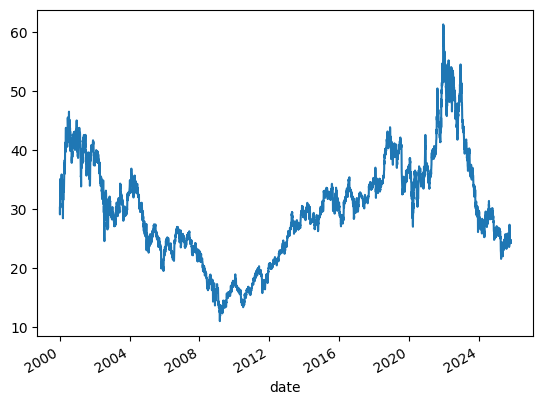

In [7]:
prices.plot()

In [8]:
train = prices.loc[:'2024-12']
test = prices.loc['2025-01':]

print(f"Training data: {len(train)} samples")
print(f"Test data: {len(test)} samples")

Training data: 6289 samples
Test data: 208 samples


In [9]:
train=pd.DataFrame(train)
train

,close
date,
2000-01-03,30.241936
2000-01-04,29.115274
2000-01-05,29.589659
2000-01-06,30.657021
2000-01-07,32.732449
...,...
2024-12-24,26.740000
2024-12-26,26.559999
2024-12-27,26.620001


In [10]:
test=pd.DataFrame(test)
test

,close
date,
2025-01-02,26.610001
2025-01-03,26.590000
2025-01-06,26.889999
2025-01-07,27.129999
2025-01-08,26.860001
...,...
2025-10-24,24.760000
2025-10-27,24.770000
2025-10-28,24.500000


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

<Axes: >

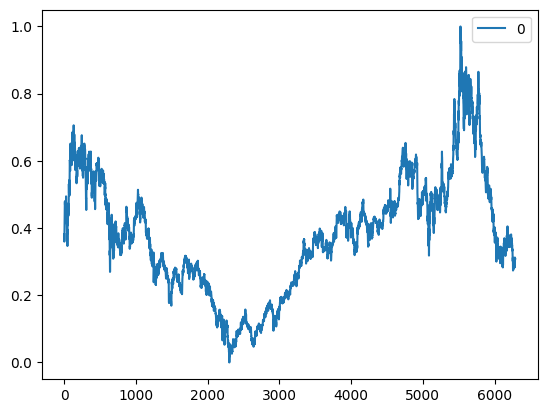

In [13]:
pd.DataFrame(train_scaled).plot()

<Axes: >

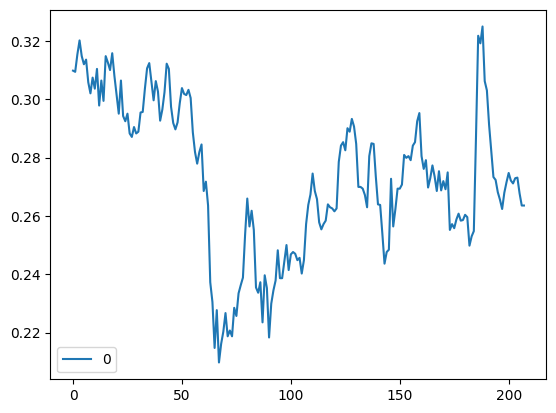

In [14]:
pd.DataFrame(test_scaled).plot()

In [15]:
print('Shape of the scaled training dataset',train_scaled.shape)
print('Shape of the unscaled training dataset',train.shape)
print('\n')
print('Shape of the scaled test dataset',test_scaled.shape)
print('Shape of the unscaled test dataset',test.shape)

Shape of the scaled training dataset (6289, 1)
Shape of the unscaled training dataset (6289, 1)


Shape of the scaled test dataset (208, 1)
Shape of the unscaled test dataset (208, 1)


In [16]:
def create_sequences(data, time_step=120):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [17]:
X_train, y_train = create_sequences(train_scaled, 120)

train_last_days = train_scaled[-120:]
test_input_data = np.concatenate((train_last_days, test_scaled), axis=0)
X_test, y_test = create_sequences(test_input_data, 120)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [19]:
X_train.shape

(6169, 120, 1)

In [20]:
X_test.shape

(208, 120, 1)

In [21]:
model = tf.keras.Sequential([
 
    LSTM(256, activation='elu', return_sequences=False, input_shape=(X_train.shape[1], 1)),
#    LSTM(128, activation='elu', return_sequences=True),
#    LSTM(64, activation='elu', return_sequences=False),
    
    
#    DenseKAN(units=256),
    
#    DenseKAN(units=128),
    
#    DenseKAN(units=64),
    
#    DenseKAN(units=32),
    
    
    
    Flatten(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


2025-12-03 18:07:43.910519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 18:07:43.945540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 18:07:43.945770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100


2025-12-03 18:07:45.784395: I external/local_xla/xla/service/service.cc:168] XLA service 0x729648d96d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 18:07:45.784421: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-03 18:07:45.789178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 18:07:45.803318: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1764806865.890663  318009 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 [==============================] - 37s 360ms/step - loss: 0.0045 - val_loss: 2.2594e-04
Epoch 2/100
97/97 [==============================] - 35s 363ms/step - loss: 2.8402e-04 - val_loss: 2.2117e-04
Epoch 3/100
97/97 [==============================] - 35s 364ms/step - loss: 2.9818e-04 - val_loss: 2.1191e-04
Epoch 4/100
97/97 [==============================] - 35s 364ms/step - loss: 2.6572e-04 - val_loss: 2.1983e-04
Epoch 5/100
97/97 [==============================] - 35s 364ms/step - loss: 2.5590e-04 - val_loss: 2.0598e-04
Epoch 6/100
97/97 [==============================] - 35s 365ms/step - loss: 2.5619e-04 - val_loss: 2.0079e-04
Epoch 7/100
97/97 [==============================] - 35s 365ms/step - loss: 2.4667e-04 - val_loss: 1.9263e-04
Epoch 8/100
97/97 [==============================] - 35s 365ms/step - loss: 2.4410e-04 - val_loss: 1.8640e-04
Epoch 9/100
97/97 [==============================] - 35s 365ms/step - loss: 2.3397e-04 - val_loss: 1.8310e-04
Epoch 10/100
97/97 [======

In [23]:
y_train_pred_kan = model.predict(X_train)
y_test_pred_kan  = model.predict(X_test)


7/7 [==============================] - 0s 16ms/step


In [24]:
y_test_original      = scaler.inverse_transform(y_test.reshape(-1,1))

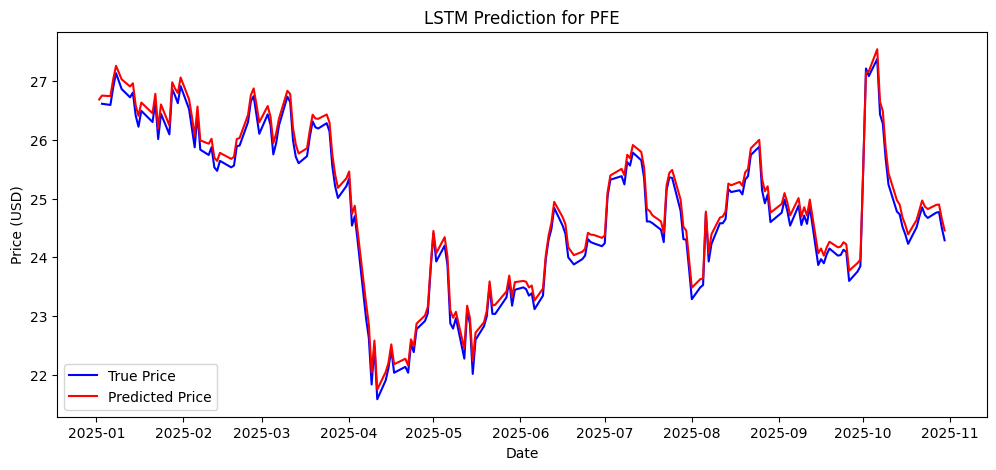

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot true test prices
plt.plot(test.index, pd.DataFrame(y_test_original).shift(1).iloc[:,0], label='True Price', color='blue')

# Plot KAN–SVR predicted prices
plt.plot(test.index, scaler.inverse_transform(y_test_pred_kan.reshape(-1, 1)), label='Predicted Price', color='red')

plt.title(f"LSTM Prediction for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

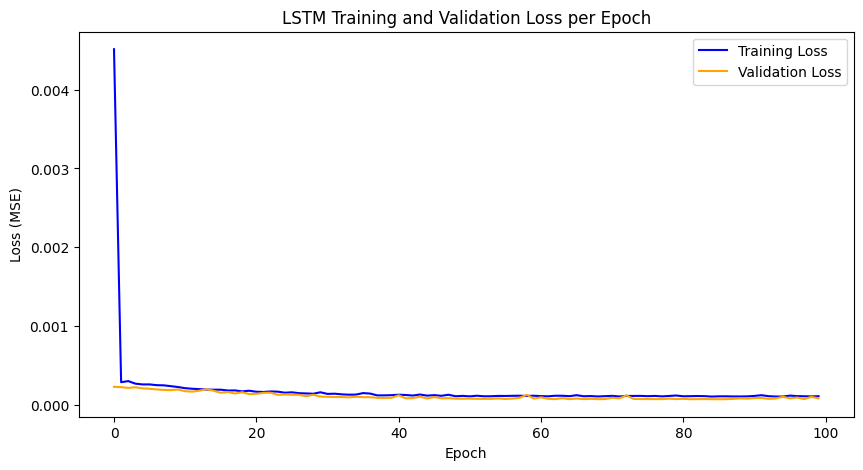

In [26]:
# ------------------ 1. Plot training & validation loss ------------------
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [27]:

# Shift true values by 1 step (like in plot)
y_true_shifted = pd.DataFrame(y_test_original).shift(1).dropna().values.flatten()

# Predicted values (skip first element to align)
y_pred = scaler.inverse_transform(y_test_pred_kan.reshape(-1, 1)).flatten()[1:]

# Align lengths
min_len = min(len(y_true_shifted), len(y_pred))
y_true_shifted = y_true_shifted[:min_len]
y_pred = y_pred[:min_len]

# Metrics
mae = mean_absolute_error(y_true_shifted, y_pred)
mse = mean_squared_error(y_true_shifted, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_shifted, y_pred)
mape = mean_absolute_percentage_error(y_true_shifted, y_pred) * 100  # in %

print("Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

Evaluation Metrics:
MAE  : 0.1406
MSE  : 0.0213
RMSE : 0.1459
R²   : 0.9876
MAPE : 0.57%
